# Esfandiar Kiani (40311614) - ML - Prj01

## Imports

In [87]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns


# Part A)

## Data Loading & Augmentations

In [72]:
LABELS  = {
    0: 'COVID',
    1: 'NORMAL'}
DATASET = "D:/M.A/T1/ML/Assignments/Prj01_Bonus/Datasets/dataset1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
class ChestXRayDataset(Dataset):
    def __init__(self, dataset_dir, transform=None, augment_covid=False, augment_normal=False):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.augment_covid = augment_covid
        self.augment_normal = augment_normal
        self.classes = ['COVID', 'NORMAL']
        self.image_paths = []
        self.labels = []
        self.augmented_images = []
        self.augmented_labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.dataset_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                self.image_paths.append(image_path)
                self.labels.append(label)

                if (self.augment_covid and label == 0) or (self.augment_normal and label == 1):
                    image = Image.open(image_path).convert('RGB')
                    augmented_images = self._augment_image(image)
                    self.augmented_images.extend(augmented_images)
                    self.augmented_labels.extend([label] * len(augmented_images))

    def __len__(self):
        return len(self.image_paths) + len(self.augmented_images)

    def __getitem__(self, idx):
        if idx < len(self.image_paths):
            image_path = self.image_paths[idx]
            image = Image.open(image_path).convert('RGB')
            label = self.labels[idx]
        else:
            image = self.augmented_images[idx - len(self.image_paths)]
            label = self.augmented_labels[idx - len(self.image_paths)]

        if self.transform:
            image = self.transform(image)

        return image, label

    def _augment_image(self, image):
        """
        1. Original
        2. Flipped
        3. 90-degree rotation
        4. 180-degree rotation
        5. 270-degree rotation
        """
        augmented_images = []

        augmented_images.append(image)

        flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        augmented_images.append(flipped_image)

        rotated_90 = image.rotate(90)
        augmented_images.append(rotated_90)

        rotated_180 = image.rotate(180)
        augmented_images.append(rotated_180)

        rotated_270 = image.rotate(270)
        augmented_images.append(rotated_270)

        return augmented_images

In [20]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

In [74]:
train_dataset = ChestXRayDataset(
    os.path.join(DATASET, 'train'),
    transform=transform,
    augment_covid=True,
    augment_normal=False
)

test_dataset = ChestXRayDataset(
    os.path.join(DATASET, 'test'),
    transform=transform,
    augment_covid=False,
    augment_normal=False
)

In [76]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
print(train_dataset.__getitem__(73), '\n\n')
print(train_dataset.__getitem__(74))

(tensor([[[0.0314, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0078],
         [0.0196, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0196, 0.0078, 0.0314,  ..., 0.0588, 0.0314, 0.0078],
         ...,
         [0.3020, 0.3216, 0.3569,  ..., 0.4157, 0.3922, 0.3569],
         [0.3176, 0.3333, 0.3686,  ..., 0.4314, 0.4000, 0.3725],
         [0.3333, 0.3451, 0.3804,  ..., 0.4510, 0.4157, 0.3843]],

        [[0.0314, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0078],
         [0.0196, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0196, 0.0078, 0.0314,  ..., 0.0588, 0.0314, 0.0078],
         ...,
         [0.3020, 0.3216, 0.3569,  ..., 0.4157, 0.3922, 0.3569],
         [0.3176, 0.3333, 0.3686,  ..., 0.4314, 0.4000, 0.3725],
         [0.3333, 0.3451, 0.3804,  ..., 0.4510, 0.4157, 0.3843]],

        [[0.0314, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0078],
         [0.0196, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0196, 0.0078, 0.0314,  ..., 0.0588, 0.0314, 0

In [36]:
def imshow(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

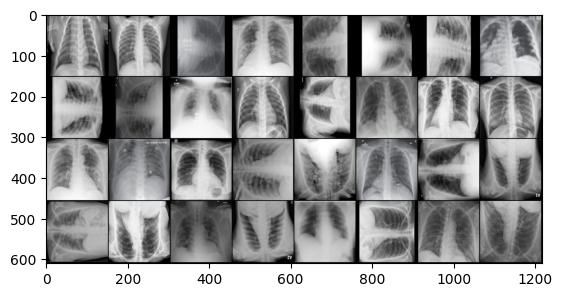

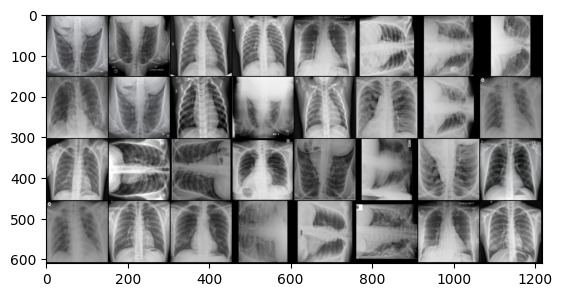

In [56]:
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

# Part B)

## Model

In [82]:
class ChestXRayCNN(nn.Module):
    def __init__(self):
        super(ChestXRayCNN, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.2)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.2)

        # Layer 4
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.2)

        # Layer 5
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn5 = nn.BatchNorm2d(256)
        self.dropout5 = nn.Dropout(0.2)

        # Layer 6
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout6 = nn.Dropout(0.2)

        # Layer 7: Flatten
        self.flatten = nn.Flatten()

        # Calculate the input size for fc1 dynamically
        self.fc1_input_size = self._get_fc1_input_size()

        # Layer 8: Dense (512, ReLU)
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout7 = nn.Dropout(0.2)

        # Layer 9: Dense (256, ReLU)
        self.fc2 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)
        self.dropout8 = nn.Dropout(0.2)

        # Layer 10: Dense (1, Sigmoid)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout4(x)

        # Layer 5
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.dropout5(x)

        # Layer 6
        x = self.conv6(x)
        x = self.pool6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.dropout6(x)

        # Layer 7: Flatten
        x = self.flatten(x)

        # Layer 8: Dense (512, ReLU)
        x = self.fc1(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.dropout7(x)

        # Layer 9: Dense (256, ReLU)
        x = self.fc2(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.dropout8(x)

        # Layer 10: Dense (1, Sigmoid)
        x = self.fc3(x)
        x = torch.sigmoid(x)

        return x

    def _get_fc1_input_size(self):
        dummy_input = torch.zeros(1, 3, 150, 150)
        x = self.conv1(dummy_input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.conv6(x)
        x = self.pool6(x)
        x = self.flatten(x)
        return x.shape[1]

In [100]:
model = ChestXRayCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training

In [124]:
train_losses = []
train_accuracies = []

In [102]:
num_epochs = 25
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels.float().view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct_train += (predicted == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

  4%|███▎                                                                               | 1/25 [00:06<02:30,  6.26s/it]

Epoch [1/25], Loss: 0.3688


  8%|██████▋                                                                            | 2/25 [00:12<02:25,  6.32s/it]

Epoch [2/25], Loss: 0.1613


 12%|█████████▉                                                                         | 3/25 [00:19<02:21,  6.42s/it]

Epoch [3/25], Loss: 0.0944


 16%|█████████████▎                                                                     | 4/25 [00:25<02:15,  6.45s/it]

Epoch [4/25], Loss: 0.0332


 20%|████████████████▌                                                                  | 5/25 [00:32<02:08,  6.43s/it]

Epoch [5/25], Loss: 0.0540


 24%|███████████████████▉                                                               | 6/25 [00:38<02:02,  6.47s/it]

Epoch [6/25], Loss: 0.1081


 28%|███████████████████████▏                                                           | 7/25 [00:45<01:56,  6.47s/it]

Epoch [7/25], Loss: 0.0696


 32%|██████████████████████████▌                                                        | 8/25 [00:51<01:49,  6.44s/it]

Epoch [8/25], Loss: 0.0460


 36%|█████████████████████████████▉                                                     | 9/25 [00:57<01:43,  6.44s/it]

Epoch [9/25], Loss: 0.1001


 40%|████████████████████████████████▊                                                 | 10/25 [01:04<01:36,  6.46s/it]

Epoch [10/25], Loss: 0.0776


 44%|████████████████████████████████████                                              | 11/25 [01:10<01:30,  6.47s/it]

Epoch [11/25], Loss: 0.0435


 48%|███████████████████████████████████████▎                                          | 12/25 [01:17<01:23,  6.45s/it]

Epoch [12/25], Loss: 0.0565


 52%|██████████████████████████████████████████▋                                       | 13/25 [01:23<01:17,  6.45s/it]

Epoch [13/25], Loss: 0.0814


 56%|█████████████████████████████████████████████▉                                    | 14/25 [01:30<01:11,  6.48s/it]

Epoch [14/25], Loss: 0.0212


 60%|█████████████████████████████████████████████████▏                                | 15/25 [01:36<01:04,  6.45s/it]

Epoch [15/25], Loss: 0.0268


 64%|████████████████████████████████████████████████████▍                             | 16/25 [01:43<00:57,  6.43s/it]

Epoch [16/25], Loss: 0.0291


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [01:49<00:51,  6.42s/it]

Epoch [17/25], Loss: 0.0225


 72%|███████████████████████████████████████████████████████████                       | 18/25 [01:55<00:44,  6.41s/it]

Epoch [18/25], Loss: 0.0289


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [02:02<00:38,  6.39s/it]

Epoch [19/25], Loss: 0.0200


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [02:08<00:31,  6.38s/it]

Epoch [20/25], Loss: 0.0063


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [02:14<00:25,  6.38s/it]

Epoch [21/25], Loss: 0.0129


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [02:21<00:19,  6.38s/it]

Epoch [22/25], Loss: 0.0114


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [02:27<00:12,  6.39s/it]

Epoch [23/25], Loss: 0.0312


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [02:34<00:06,  6.45s/it]

Epoch [24/25], Loss: 0.0065


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:40<00:00,  6.44s/it]

Epoch [25/25], Loss: 0.0085


# Part C)

## Evaluating Model

In [103]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [104]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
sensitivity = recall_score(all_labels, all_preds) 
specificity = recall_score(all_labels, all_preds, pos_label=0)
f1 = f1_score(all_labels, all_preds)

In [105]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9500
Precision: 1.0000
Sensitivity (Recall): 0.9000
Specificity: 1.0000
F1 Score: 0.9474


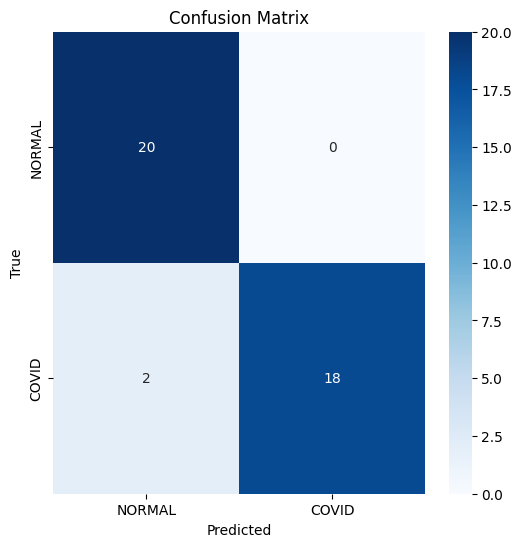

In [106]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NORMAL", "COVID"], yticklabels=["NORMAL", "COVID"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

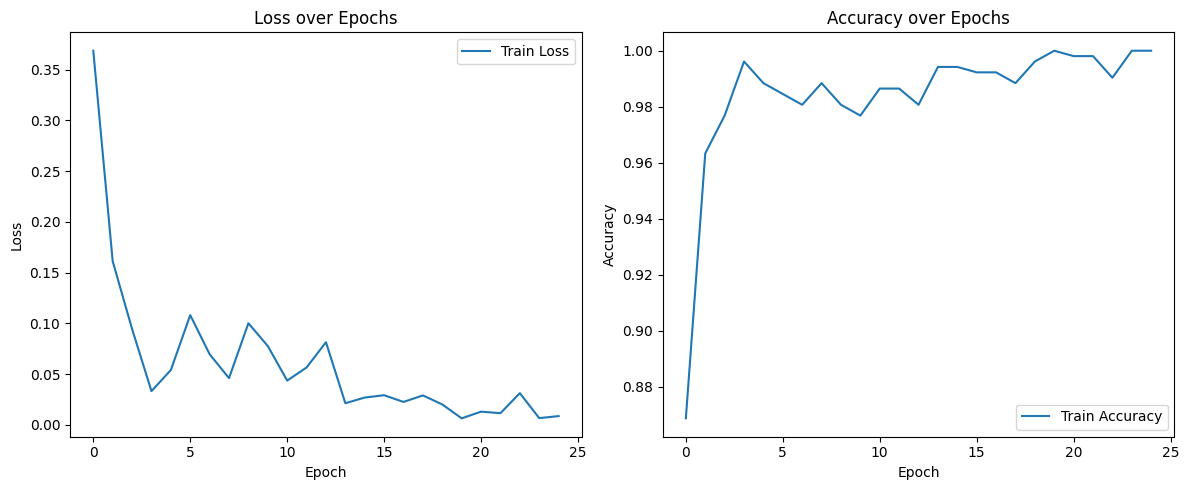

In [123]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# Part D)

In [159]:
train_acc = [1, ]
test_acc  = [1, ]

### One Conv 2D

In [160]:
class ChestXRayCNN1(nn.Module):
    def __init__(self):
        super(ChestXRayCNN1, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)

        # Layer 7: Flatten
        self.flatten = nn.Flatten()

        # Calculate the input size for fc1 dynamically
        self.fc1_input_size = self._get_fc1_input_size()

        # Layer 8: Dense (512, ReLU)
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout7 = nn.Dropout(0.2)

        # Layer 9: Dense (256, ReLU)
        self.fc2 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)
        self.dropout8 = nn.Dropout(0.2)

        # Layer 10: Dense (1, Sigmoid)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Layer 7: Flatten
        x = self.flatten(x)

        # Layer 8: Dense (512, ReLU)
        x = self.fc1(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.dropout7(x)

        # Layer 9: Dense (256, ReLU)
        x = self.fc2(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.dropout8(x)

        # Layer 10: Dense (1, Sigmoid)
        x = self.fc3(x)
        x = torch.sigmoid(x)

        return x

    def _get_fc1_input_size(self):
        dummy_input = torch.zeros(1, 3, 150, 150)
        
        x = self.conv1(dummy_input)
        x = self.pool1(x)
        
        x = self.flatten(x)
        return x.shape[1]

In [161]:
model1 = ChestXRayCNN1().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [162]:
num_epochs = 25
for epoch in tqdm(range(num_epochs)):
    model1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model1(images)
        loss = criterion(outputs, labels.float().view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct_train += (predicted == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    loss = running_loss / len(train_loader)
    accuracy = correct_train / total_train

    if epoch == num_epochs-1:
        train_acc.append(accuracy)

  4%|███▎                                                                               | 1/25 [00:20<08:21, 20.91s/it]

Epoch [1/25], Loss: 0.3460


  8%|██████▋                                                                            | 2/25 [00:40<07:46, 20.29s/it]

Epoch [2/25], Loss: 0.1191


 12%|█████████▉                                                                         | 3/25 [01:00<07:25, 20.23s/it]

Epoch [3/25], Loss: 0.0659


 16%|█████████████▎                                                                     | 4/25 [01:21<07:05, 20.24s/it]

Epoch [4/25], Loss: 0.0391


 20%|████████████████▌                                                                  | 5/25 [01:41<06:42, 20.11s/it]

Epoch [5/25], Loss: 0.0301


 24%|███████████████████▉                                                               | 6/25 [02:00<06:19, 19.98s/it]

Epoch [6/25], Loss: 0.0189


 28%|███████████████████████▏                                                           | 7/25 [02:20<05:57, 19.84s/it]

Epoch [7/25], Loss: 0.0132


 32%|██████████████████████████▌                                                        | 8/25 [02:39<05:35, 19.73s/it]

Epoch [8/25], Loss: 0.0213


 36%|█████████████████████████████▉                                                     | 9/25 [02:59<05:14, 19.68s/it]

Epoch [9/25], Loss: 0.0169


 40%|████████████████████████████████▊                                                 | 10/25 [03:19<04:54, 19.65s/it]

Epoch [10/25], Loss: 0.0094


 44%|████████████████████████████████████                                              | 11/25 [03:38<04:34, 19.63s/it]

Epoch [11/25], Loss: 0.0274


 48%|███████████████████████████████████████▎                                          | 12/25 [03:58<04:15, 19.64s/it]

Epoch [12/25], Loss: 0.0501


 52%|██████████████████████████████████████████▋                                       | 13/25 [04:17<03:55, 19.63s/it]

Epoch [13/25], Loss: 0.0402


 56%|█████████████████████████████████████████████▉                                    | 14/25 [04:37<03:35, 19.63s/it]

Epoch [14/25], Loss: 0.0326


 60%|█████████████████████████████████████████████████▏                                | 15/25 [04:57<03:16, 19.66s/it]

Epoch [15/25], Loss: 0.0236


 64%|████████████████████████████████████████████████████▍                             | 16/25 [05:16<02:56, 19.66s/it]

Epoch [16/25], Loss: 0.0087


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [05:36<02:37, 19.67s/it]

Epoch [17/25], Loss: 0.0086


 72%|███████████████████████████████████████████████████████████                       | 18/25 [05:56<02:17, 19.65s/it]

Epoch [18/25], Loss: 0.0041


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [06:16<01:58, 19.79s/it]

Epoch [19/25], Loss: 0.0034


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [06:36<01:39, 19.80s/it]

Epoch [20/25], Loss: 0.0065


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [06:55<01:19, 19.78s/it]

Epoch [21/25], Loss: 0.0048


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [07:15<00:59, 19.73s/it]

Epoch [22/25], Loss: 0.0042


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [07:35<00:39, 19.69s/it]

Epoch [23/25], Loss: 0.0023


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [07:54<00:19, 19.66s/it]

Epoch [24/25], Loss: 0.0028


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [08:14<00:00, 19.77s/it]

Epoch [25/25], Loss: 0.0399


In [163]:
model1.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model1(images)
        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
print(accuracy)
test_acc.append(accuracy)

0.975


### Two Conv 2D

In [164]:
class ChestXRayCNN2(nn.Module):
    def __init__(self):
        super(ChestXRayCNN2, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.2)

        # Layer 7: Flatten
        self.flatten = nn.Flatten()

        # Calculate the input size for fc1 dynamically
        self.fc1_input_size = self._get_fc1_input_size()

        # Layer 8: Dense (512, ReLU)
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout7 = nn.Dropout(0.2)

        # Layer 9: Dense (256, ReLU)
        self.fc2 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)
        self.dropout8 = nn.Dropout(0.2)

        # Layer 10: Dense (1, Sigmoid)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Layer 7: Flatten
        x = self.flatten(x)

        # Layer 8: Dense (512, ReLU)
        x = self.fc1(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.dropout7(x)

        # Layer 9: Dense (256, ReLU)
        x = self.fc2(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.dropout8(x)

        # Layer 10: Dense (1, Sigmoid)
        x = self.fc3(x)
        x = torch.sigmoid(x)

        return x

    def _get_fc1_input_size(self):
        dummy_input = torch.zeros(1, 3, 150, 150)
        
        x = self.conv1(dummy_input)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        return x.shape[1]

In [165]:
model2 = ChestXRayCNN2().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [166]:
num_epochs = 25
for epoch in tqdm(range(num_epochs)):
    model2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model2(images)
        loss = criterion(outputs, labels.float().view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct_train += (predicted == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    loss = running_loss / len(train_loader)
    accuracy = correct_train / total_train

    if epoch == num_epochs-1:
        train_acc.append(accuracy)

  4%|███▎                                                                               | 1/25 [00:06<02:32,  6.35s/it]

Epoch [1/25], Loss: 0.2352


  8%|██████▋                                                                            | 2/25 [00:12<02:28,  6.46s/it]

Epoch [2/25], Loss: 0.0751


 12%|█████████▉                                                                         | 3/25 [00:19<02:23,  6.51s/it]

Epoch [3/25], Loss: 0.0259


 16%|█████████████▎                                                                     | 4/25 [00:26<02:17,  6.53s/it]

Epoch [4/25], Loss: 0.0228


 20%|████████████████▌                                                                  | 5/25 [00:33<02:13,  6.69s/it]

Epoch [5/25], Loss: 0.0133


 24%|███████████████████▉                                                               | 6/25 [00:39<02:07,  6.70s/it]

Epoch [6/25], Loss: 0.0108


 28%|███████████████████████▏                                                           | 7/25 [00:46<02:00,  6.68s/it]

Epoch [7/25], Loss: 0.0093


 32%|██████████████████████████▌                                                        | 8/25 [00:52<01:53,  6.67s/it]

Epoch [8/25], Loss: 0.0136


 36%|█████████████████████████████▉                                                     | 9/25 [00:59<01:47,  6.75s/it]

Epoch [9/25], Loss: 0.0131


 40%|████████████████████████████████▊                                                 | 10/25 [01:06<01:40,  6.73s/it]

Epoch [10/25], Loss: 0.0097


 44%|████████████████████████████████████                                              | 11/25 [01:13<01:36,  6.86s/it]

Epoch [11/25], Loss: 0.0078


 48%|███████████████████████████████████████▎                                          | 12/25 [01:20<01:29,  6.91s/it]

Epoch [12/25], Loss: 0.0044


 52%|██████████████████████████████████████████▋                                       | 13/25 [01:27<01:21,  6.80s/it]

Epoch [13/25], Loss: 0.0059


 56%|█████████████████████████████████████████████▉                                    | 14/25 [01:33<01:13,  6.72s/it]

Epoch [14/25], Loss: 0.0040


 60%|█████████████████████████████████████████████████▏                                | 15/25 [01:40<01:07,  6.72s/it]

Epoch [15/25], Loss: 0.0032


 64%|████████████████████████████████████████████████████▍                             | 16/25 [01:47<01:00,  6.69s/it]

Epoch [16/25], Loss: 0.0152


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [01:53<00:53,  6.71s/it]

Epoch [17/25], Loss: 0.0101


 72%|███████████████████████████████████████████████████████████                       | 18/25 [02:00<00:46,  6.69s/it]

Epoch [18/25], Loss: 0.0053


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [02:07<00:39,  6.62s/it]

Epoch [19/25], Loss: 0.0129


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [02:13<00:32,  6.60s/it]

Epoch [20/25], Loss: 0.0236


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [02:20<00:26,  6.54s/it]

Epoch [21/25], Loss: 0.0132


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [02:26<00:19,  6.51s/it]

Epoch [22/25], Loss: 0.0069


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [02:32<00:12,  6.48s/it]

Epoch [23/25], Loss: 0.0041


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [02:39<00:06,  6.48s/it]

Epoch [24/25], Loss: 0.0024


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.63s/it]

Epoch [25/25], Loss: 0.0011


In [167]:
model2.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model2(images)
        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
test_acc.append(accuracy)
print(accuracy)

1.0


### Three Conv 2D

In [168]:
class ChestXRayCNN3(nn.Module):
    def __init__(self):
        super(ChestXRayCNN3, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.2)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.2)
        
        # Layer 7: Flatten
        self.flatten = nn.Flatten()

        # Calculate the input size for fc1 dynamically
        self.fc1_input_size = self._get_fc1_input_size()

        # Layer 8: Dense (512, ReLU)
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout7 = nn.Dropout(0.2)

        # Layer 9: Dense (256, ReLU)
        self.fc2 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)
        self.dropout8 = nn.Dropout(0.2)

        # Layer 10: Dense (1, Sigmoid)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        # Layer 7: Flatten
        x = self.flatten(x)

        # Layer 8: Dense (512, ReLU)
        x = self.fc1(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.dropout7(x)

        # Layer 9: Dense (256, ReLU)
        x = self.fc2(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.dropout8(x)

        # Layer 10: Dense (1, Sigmoid)
        x = self.fc3(x)
        x = torch.sigmoid(x)

        return x

    def _get_fc1_input_size(self):
        dummy_input = torch.zeros(1, 3, 150, 150)
        
        x = self.conv1(dummy_input)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        return x.shape[1]

In [169]:
model3 = ChestXRayCNN3().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

In [170]:
num_epochs = 25
for epoch in tqdm(range(num_epochs)):
    model3.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model3(images)
        loss = criterion(outputs, labels.float().view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct_train += (predicted == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    loss = running_loss / len(train_loader)
    accuracy = correct_train / total_train

    if epoch == num_epochs-1:
        train_acc.append(accuracy)

  4%|███▎                                                                               | 1/25 [00:06<02:34,  6.42s/it]

Epoch [1/25], Loss: 0.2545


  8%|██████▋                                                                            | 2/25 [00:12<02:27,  6.39s/it]

Epoch [2/25], Loss: 0.0798


 12%|█████████▉                                                                         | 3/25 [00:19<02:20,  6.39s/it]

Epoch [3/25], Loss: 0.0481


 16%|█████████████▎                                                                     | 4/25 [00:25<02:14,  6.38s/it]

Epoch [4/25], Loss: 0.0517


 20%|████████████████▌                                                                  | 5/25 [00:31<02:07,  6.40s/it]

Epoch [5/25], Loss: 0.0492


 24%|███████████████████▉                                                               | 6/25 [00:38<02:01,  6.40s/it]

Epoch [6/25], Loss: 0.0299


 28%|███████████████████████▏                                                           | 7/25 [00:44<01:55,  6.39s/it]

Epoch [7/25], Loss: 0.0191


 32%|██████████████████████████▌                                                        | 8/25 [00:51<01:48,  6.37s/it]

Epoch [8/25], Loss: 0.0146


 36%|█████████████████████████████▉                                                     | 9/25 [00:57<01:42,  6.38s/it]

Epoch [9/25], Loss: 0.0143


 40%|████████████████████████████████▊                                                 | 10/25 [01:03<01:36,  6.40s/it]

Epoch [10/25], Loss: 0.0082


 44%|████████████████████████████████████                                              | 11/25 [01:10<01:29,  6.42s/it]

Epoch [11/25], Loss: 0.0084


 48%|███████████████████████████████████████▎                                          | 12/25 [01:16<01:24,  6.48s/it]

Epoch [12/25], Loss: 0.0158


 52%|██████████████████████████████████████████▋                                       | 13/25 [01:23<01:19,  6.59s/it]

Epoch [13/25], Loss: 0.0377


 56%|█████████████████████████████████████████████▉                                    | 14/25 [01:30<01:12,  6.62s/it]

Epoch [14/25], Loss: 0.0175


 60%|█████████████████████████████████████████████████▏                                | 15/25 [01:36<01:05,  6.55s/it]

Epoch [15/25], Loss: 0.0320


 64%|████████████████████████████████████████████████████▍                             | 16/25 [01:43<00:58,  6.50s/it]

Epoch [16/25], Loss: 0.0330


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [01:49<00:52,  6.51s/it]

Epoch [17/25], Loss: 0.0183


 72%|███████████████████████████████████████████████████████████                       | 18/25 [01:56<00:45,  6.48s/it]

Epoch [18/25], Loss: 0.0265


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [02:02<00:38,  6.48s/it]

Epoch [19/25], Loss: 0.0304


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [02:10<00:34,  6.89s/it]

Epoch [20/25], Loss: 0.0138


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [02:19<00:30,  7.53s/it]

Epoch [21/25], Loss: 0.0102


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [02:26<00:21,  7.32s/it]

Epoch [22/25], Loss: 0.0048


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [02:32<00:14,  7.07s/it]

Epoch [23/25], Loss: 0.0043


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [02:39<00:06,  6.98s/it]

Epoch [24/25], Loss: 0.0038


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:46<00:00,  6.66s/it]

Epoch [25/25], Loss: 0.0016


In [171]:
model3.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model3(images)
        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
test_acc.append(accuracy)
print(accuracy)

0.975


### Four Conv 2D

In [172]:
class ChestXRayCNN4(nn.Module):
    def __init__(self):
        super(ChestXRayCNN4, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.2)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.2)

        # Layer 4
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.2)

        # Layer 7: Flatten
        self.flatten = nn.Flatten()

        # Calculate the input size for fc1 dynamically
        self.fc1_input_size = self._get_fc1_input_size()

        # Layer 8: Dense (512, ReLU)
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout7 = nn.Dropout(0.2)

        # Layer 9: Dense (256, ReLU)
        self.fc2 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)
        self.dropout8 = nn.Dropout(0.2)

        # Layer 10: Dense (1, Sigmoid)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout4(x)

        # Layer 7: Flatten
        x = self.flatten(x)

        # Layer 8: Dense (512, ReLU)
        x = self.fc1(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.dropout7(x)

        # Layer 9: Dense (256, ReLU)
        x = self.fc2(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.dropout8(x)

        # Layer 10: Dense (1, Sigmoid)
        x = self.fc3(x)
        x = torch.sigmoid(x)

        return x

    def _get_fc1_input_size(self):
        dummy_input = torch.zeros(1, 3, 150, 150)
        
        x = self.conv1(dummy_input)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.pool4(x)
        
        x = self.flatten(x)
        return x.shape[1]

In [173]:
model4 = ChestXRayCNN4().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model4.parameters(), lr=0.001)

In [174]:
num_epochs = 25
for epoch in tqdm(range(num_epochs)):
    model4.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model4(images)
        loss = criterion(outputs, labels.float().view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct_train += (predicted == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    loss = running_loss / len(train_loader)
    accuracy = correct_train / total_train

    if epoch == num_epochs-1:
        train_acc.append(accuracy)

  4%|███▎                                                                               | 1/25 [00:06<02:45,  6.88s/it]

Epoch [1/25], Loss: 0.3184


  8%|██████▋                                                                            | 2/25 [00:13<02:34,  6.72s/it]

Epoch [2/25], Loss: 0.0725


 12%|█████████▉                                                                         | 3/25 [00:20<02:26,  6.64s/it]

Epoch [3/25], Loss: 0.0427


 16%|█████████████▎                                                                     | 4/25 [00:26<02:19,  6.62s/it]

Epoch [4/25], Loss: 0.0411


 20%|████████████████▌                                                                  | 5/25 [00:33<02:11,  6.56s/it]

Epoch [5/25], Loss: 0.0202


 24%|███████████████████▉                                                               | 6/25 [00:39<02:04,  6.54s/it]

Epoch [6/25], Loss: 0.0508


 28%|███████████████████████▏                                                           | 7/25 [00:46<01:59,  6.62s/it]

Epoch [7/25], Loss: 0.0549


 32%|██████████████████████████▌                                                        | 8/25 [00:52<01:52,  6.59s/it]

Epoch [8/25], Loss: 0.0257


 36%|█████████████████████████████▉                                                     | 9/25 [00:59<01:44,  6.52s/it]

Epoch [9/25], Loss: 0.0227


 40%|████████████████████████████████▊                                                 | 10/25 [01:05<01:38,  6.56s/it]

Epoch [10/25], Loss: 0.0486


 44%|████████████████████████████████████                                              | 11/25 [01:13<01:34,  6.75s/it]

Epoch [11/25], Loss: 0.0474


 48%|███████████████████████████████████████▎                                          | 12/25 [01:19<01:27,  6.74s/it]

Epoch [12/25], Loss: 0.0305


 52%|██████████████████████████████████████████▋                                       | 13/25 [01:26<01:19,  6.67s/it]

Epoch [13/25], Loss: 0.0261


 56%|█████████████████████████████████████████████▉                                    | 14/25 [01:32<01:12,  6.59s/it]

Epoch [14/25], Loss: 0.0401


 60%|█████████████████████████████████████████████████▏                                | 15/25 [01:39<01:05,  6.59s/it]

Epoch [15/25], Loss: 0.0159


 64%|████████████████████████████████████████████████████▍                             | 16/25 [01:45<00:58,  6.55s/it]

Epoch [16/25], Loss: 0.0108


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [01:52<00:52,  6.52s/it]

Epoch [17/25], Loss: 0.0160


 72%|███████████████████████████████████████████████████████████                       | 18/25 [01:58<00:45,  6.48s/it]

Epoch [18/25], Loss: 0.0102


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [02:05<00:38,  6.48s/it]

Epoch [19/25], Loss: 0.0061


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [02:11<00:32,  6.47s/it]

Epoch [20/25], Loss: 0.0028


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [02:17<00:25,  6.45s/it]

Epoch [21/25], Loss: 0.0252


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [02:24<00:19,  6.46s/it]

Epoch [22/25], Loss: 0.0137


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [02:30<00:12,  6.44s/it]

Epoch [23/25], Loss: 0.0321


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [02:37<00:06,  6.42s/it]

Epoch [24/25], Loss: 0.0583


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:43<00:00,  6.54s/it]

Epoch [25/25], Loss: 0.0220


In [175]:
model4.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model4(images)
        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
test_acc.append(accuracy)
print(accuracy)

1.0


### Five Conv 2D

In [176]:
class ChestXRayCNN5(nn.Module):
    def __init__(self):
        super(ChestXRayCNN5, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.2)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.2)

        # Layer 4
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.2)

        # Layer 5
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn5 = nn.BatchNorm2d(256)
        self.dropout5 = nn.Dropout(0.2)

        # Layer 7: Flatten
        self.flatten = nn.Flatten()

        # Calculate the input size for fc1 dynamically
        self.fc1_input_size = self._get_fc1_input_size()

        # Layer 8: Dense (512, ReLU)
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout7 = nn.Dropout(0.2)

        # Layer 9: Dense (256, ReLU)
        self.fc2 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)
        self.dropout8 = nn.Dropout(0.2)

        # Layer 10: Dense (1, Sigmoid)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout4(x)

        # Layer 5
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.dropout5(x)

        # Layer 7: Flatten
        x = self.flatten(x)

        # Layer 8: Dense (512, ReLU)
        x = self.fc1(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.dropout7(x)

        # Layer 9: Dense (256, ReLU)
        x = self.fc2(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.dropout8(x)

        # Layer 10: Dense (1, Sigmoid)
        x = self.fc3(x)
        x = torch.sigmoid(x)

        return x

    def _get_fc1_input_size(self):
        dummy_input = torch.zeros(1, 3, 150, 150)
        
        x = self.conv1(dummy_input)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.pool4(x)
        
        x = self.conv5(x)
        x = self.pool5(x)
        
        x = self.flatten(x)
        return x.shape[1]

In [177]:
model5 = ChestXRayCNN5().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model5.parameters(), lr=0.001)

In [178]:
num_epochs = 25
for epoch in tqdm(range(num_epochs)):
    model5.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model5(images)
        loss = criterion(outputs, labels.float().view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct_train += (predicted == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    loss = running_loss / len(train_loader)
    accuracy = correct_train / total_train

    if epoch == num_epochs-1:
        train_acc.append(accuracy)

  4%|███▎                                                                               | 1/25 [00:06<02:34,  6.44s/it]

Epoch [1/25], Loss: 0.3701


  8%|██████▋                                                                            | 2/25 [00:12<02:27,  6.41s/it]

Epoch [2/25], Loss: 0.0893


 12%|█████████▉                                                                         | 3/25 [00:19<02:21,  6.41s/it]

Epoch [3/25], Loss: 0.0588


 16%|█████████████▎                                                                     | 4/25 [00:25<02:14,  6.41s/it]

Epoch [4/25], Loss: 0.0633


 20%|████████████████▌                                                                  | 5/25 [00:32<02:08,  6.42s/it]

Epoch [5/25], Loss: 0.0465


 24%|███████████████████▉                                                               | 6/25 [00:38<02:01,  6.42s/it]

Epoch [6/25], Loss: 0.0342


 28%|███████████████████████▏                                                           | 7/25 [00:45<01:56,  6.45s/it]

Epoch [7/25], Loss: 0.0506


 32%|██████████████████████████▌                                                        | 8/25 [00:51<01:49,  6.43s/it]

Epoch [8/25], Loss: 0.0481


 36%|█████████████████████████████▉                                                     | 9/25 [00:57<01:42,  6.43s/it]

Epoch [9/25], Loss: 0.0327


 40%|████████████████████████████████▊                                                 | 10/25 [01:04<01:36,  6.41s/it]

Epoch [10/25], Loss: 0.0243


 44%|████████████████████████████████████                                              | 11/25 [01:10<01:29,  6.42s/it]

Epoch [11/25], Loss: 0.0133


 48%|███████████████████████████████████████▎                                          | 12/25 [01:16<01:23,  6.40s/it]

Epoch [12/25], Loss: 0.0384


 52%|██████████████████████████████████████████▋                                       | 13/25 [01:23<01:18,  6.54s/it]

Epoch [13/25], Loss: 0.0437


 56%|█████████████████████████████████████████████▉                                    | 14/25 [01:30<01:12,  6.58s/it]

Epoch [14/25], Loss: 0.0384


 60%|█████████████████████████████████████████████████▏                                | 15/25 [01:36<01:05,  6.54s/it]

Epoch [15/25], Loss: 0.0190


 64%|████████████████████████████████████████████████████▍                             | 16/25 [01:43<00:58,  6.53s/it]

Epoch [16/25], Loss: 0.0135


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [01:49<00:51,  6.48s/it]

Epoch [17/25], Loss: 0.0105


 72%|███████████████████████████████████████████████████████████                       | 18/25 [01:56<00:45,  6.46s/it]

Epoch [18/25], Loss: 0.0052


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [02:02<00:39,  6.51s/it]

Epoch [19/25], Loss: 0.0057


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [02:09<00:32,  6.50s/it]

Epoch [20/25], Loss: 0.0047


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [02:15<00:25,  6.48s/it]

Epoch [21/25], Loss: 0.0070


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [02:22<00:19,  6.47s/it]

Epoch [22/25], Loss: 0.0734


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [02:28<00:13,  6.52s/it]

Epoch [23/25], Loss: 0.0096


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [02:35<00:06,  6.51s/it]

Epoch [24/25], Loss: 0.0143


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.48s/it]

Epoch [25/25], Loss: 0.0108


In [179]:
model5.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model5(images)
        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
test_acc.append(accuracy)
print(accuracy)

0.85


### Six Conv 2D

In [180]:
class ChestXRayCNN6(nn.Module):
    def __init__(self):
        super(ChestXRayCNN6, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.2)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.2)

        # Layer 4
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.2)

        # Layer 5
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn5 = nn.BatchNorm2d(256)
        self.dropout5 = nn.Dropout(0.2)

        # Layer 6
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout6 = nn.Dropout(0.2)

        # Layer 7: Flatten
        self.flatten = nn.Flatten()

        # Calculate the input size for fc1 dynamically
        self.fc1_input_size = self._get_fc1_input_size()

        # Layer 8: Dense (512, ReLU)
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout7 = nn.Dropout(0.2)

        # Layer 9: Dense (256, ReLU)
        self.fc2 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)
        self.dropout8 = nn.Dropout(0.2)

        # Layer 10: Dense (1, Sigmoid)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout4(x)

        # Layer 5
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.dropout5(x)

        # Layer 6
        x = self.conv6(x)
        x = self.pool6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.dropout6(x)

        # Layer 7: Flatten
        x = self.flatten(x)

        # Layer 8: Dense (512, ReLU)
        x = self.fc1(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.dropout7(x)

        # Layer 9: Dense (256, ReLU)
        x = self.fc2(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.dropout8(x)

        # Layer 10: Dense (1, Sigmoid)
        x = self.fc3(x)
        x = torch.sigmoid(x)

        return x

    def _get_fc1_input_size(self):
        dummy_input = torch.zeros(1, 3, 150, 150)
        x = self.conv1(dummy_input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.conv6(x)
        x = self.pool6(x)
        x = self.flatten(x)
        return x.shape[1]

In [181]:
model6 = ChestXRayCNN6().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model6.parameters(), lr=0.001)

In [182]:
num_epochs = 25
for epoch in tqdm(range(num_epochs)):
    model6.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model6(images)
        loss = criterion(outputs, labels.float().view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct_train += (predicted == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    loss = running_loss / len(train_loader)
    accuracy = correct_train / total_train

    if epoch == num_epochs-1:
        train_acc.append(accuracy)

  4%|███▎                                                                               | 1/25 [00:06<02:36,  6.50s/it]

Epoch [1/25], Loss: 0.4174


  8%|██████▋                                                                            | 2/25 [00:12<02:28,  6.45s/it]

Epoch [2/25], Loss: 0.1361


 12%|█████████▉                                                                         | 3/25 [00:19<02:22,  6.50s/it]

Epoch [3/25], Loss: 0.0709


 16%|█████████████▎                                                                     | 4/25 [00:26<02:18,  6.61s/it]

Epoch [4/25], Loss: 0.0545


 20%|████████████████▌                                                                  | 5/25 [00:32<02:10,  6.55s/it]

Epoch [5/25], Loss: 0.0496


 24%|███████████████████▉                                                               | 6/25 [00:39<02:03,  6.51s/it]

Epoch [6/25], Loss: 0.0581


 28%|███████████████████████▏                                                           | 7/25 [00:45<01:57,  6.51s/it]

Epoch [7/25], Loss: 0.0491


 32%|██████████████████████████▌                                                        | 8/25 [00:52<01:50,  6.49s/it]

Epoch [8/25], Loss: 0.0658


 36%|█████████████████████████████▉                                                     | 9/25 [00:58<01:43,  6.48s/it]

Epoch [9/25], Loss: 0.0388


 40%|████████████████████████████████▊                                                 | 10/25 [01:04<01:36,  6.45s/it]

Epoch [10/25], Loss: 0.0260


 44%|████████████████████████████████████                                              | 11/25 [01:11<01:30,  6.50s/it]

Epoch [11/25], Loss: 0.0824


 48%|███████████████████████████████████████▎                                          | 12/25 [01:17<01:23,  6.46s/it]

Epoch [12/25], Loss: 0.0310


 52%|██████████████████████████████████████████▋                                       | 13/25 [01:24<01:17,  6.47s/it]

Epoch [13/25], Loss: 0.0462


 56%|█████████████████████████████████████████████▉                                    | 14/25 [01:30<01:10,  6.45s/it]

Epoch [14/25], Loss: 0.0247


 60%|█████████████████████████████████████████████████▏                                | 15/25 [01:37<01:04,  6.45s/it]

Epoch [15/25], Loss: 0.0073


 64%|████████████████████████████████████████████████████▍                             | 16/25 [01:43<00:58,  6.45s/it]

Epoch [16/25], Loss: 0.0102


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [01:50<00:51,  6.43s/it]

Epoch [17/25], Loss: 0.0054


 72%|███████████████████████████████████████████████████████████                       | 18/25 [01:56<00:44,  6.41s/it]

Epoch [18/25], Loss: 0.0155


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [02:02<00:38,  6.42s/it]

Epoch [19/25], Loss: 0.0469


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [02:09<00:32,  6.41s/it]

Epoch [20/25], Loss: 0.0951


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [02:15<00:25,  6.41s/it]

Epoch [21/25], Loss: 0.0611


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [02:22<00:19,  6.40s/it]

Epoch [22/25], Loss: 0.0454


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [02:28<00:12,  6.40s/it]

Epoch [23/25], Loss: 0.0185


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [02:34<00:06,  6.41s/it]

Epoch [24/25], Loss: 0.0380


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.45s/it]

Epoch [25/25], Loss: 0.0258


In [183]:
model6.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model6(images)
        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
test_acc.append(accuracy)
print(accuracy)

0.925


## Plot Total Eval Result

Same as Table 6

C:\Users\Stephen\AppData\Local\Temp\ipykernel_4144\815720534.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\Stephen\AppData\Local\Temp\ipykernel_4144\815720534.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


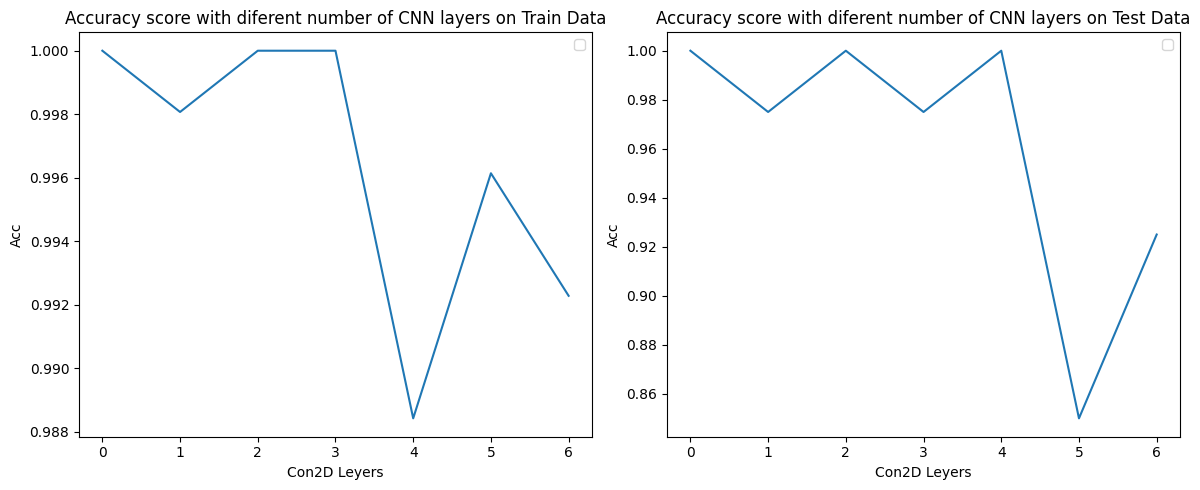

In [184]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc)
plt.xlabel("Con2D Leyers")
plt.ylabel("Acc")
plt.title("Accuracy score with diferent number of CNN layers on Train Data")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_acc)
plt.xlabel("Con2D Leyers")
plt.ylabel("Acc")
plt.title("Accuracy score with diferent number of CNN layers on Test Data")
plt.legend()

plt.tight_layout()
plt.show()